Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

# Building a basic predictive maintenance model

Simply put, **predictive maintenance (PdM)** is about pre-emptively finding and fixing flaws in a system (as long as it collects data over time, using sensors for example) in order to reduce downtime. Given a failure in some component or part of the system, we are asking how likely it is that this would result in system failure and downtime soon after. 

## Loading and examining the data

In [1]:
import os # standard lib for OS operations

import urllib.request # for downloading data

# plotting libs
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(15,8)}) # set figure size

# ML classifiers and the like
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn import svm

# metrics for evaluating results
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

In [2]:
os.makedirs('../data', exist_ok = True)
container = 'https://sethmottstore.blob.core.windows.net/predmaint/'
urllib.request.urlretrieve(container + 'telemetry.csv', filename='../data/telemetry.csv')
urllib.request.urlretrieve(container + 'maintenance.csv', filename='../data/maintenance.csv')
urllib.request.urlretrieve(container + 'machines.csv', filename='../data/machines.csv')
urllib.request.urlretrieve(container + 'failures.csv', filename='../data/failures.csv')
urllib.request.urlretrieve(container + 'errors.csv', filename='../data/errors.csv')
urllib.request.urlretrieve(container + 'anoms.csv', filename='../data/anoms.csv')
#urllib.request.urlretrieve(container + 'telemetry_w_anoms.csv', filename='../data/telemetry_w_anoms.csv')

('../data/anoms.csv', <http.client.HTTPMessage at 0x7f7c3d019278>)

The relevant data sources for predictive maintenance include, but are not limited to:
  - **Machine operating conditions:** data of the equipment health over time (usually sensor-based and streaming). We will refer to this data as machine *telemetry data*.
  - **Error histor:** this data contains logs of *non-breaking* errors that happen thoughout a machine's operation and which parts of the machine they came from
  - **Failure history:** this data contains logs of severe errors that broke the machine down (requiring maintenance to operate again) and parts of the machine that caused it
  - **Maintenance/repair history:** what parts were fixed/replaced (as part of scheduled maintenance or due to failure) and when
  - **Equipment metadata:** anything we know about equipment and parts (such as make, model, etc.)

### Quiz

<div class="alert alert-info">
Pick two of the use cases [mentioned earlier](#usecases), and provide examples of the four kinds of data needed to perform PdM for those use cases.
</div>

In [3]:
# write solution here

From now on we will adopt to following consistent terminology to avoid confusion:

- A system as a whole will be called a **machine** and its parts are called **components**
- A machine can experience **errors** when anomalies happen. Errors do NOT result in shutdown, and they are NOT tied to any particular components, but they can cause one or several component to *eventually* fail.
- A machine can experience **failure** when one of its components shuts down. This requires the component to be replaced before the machine can be operational again.
- For our purposes, **maintenance** means a component was replaced. This can be either as part of a routine schedule or because the component failed (prior to its scheduled maintenance).

Let's now begin loading all the data and looking at the kind of information it contains. We begin with the telemetry data.

In [4]:
import pandas as pd

df_telemetry = pd.read_csv('../data/telemetry.csv', header=0)
df_telemetry['datetime'] = pd.to_datetime(df_telemetry['datetime'], format="%m/%d/%Y %I:%M:%S %p")
df_telemetry.head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


Here's an example of the voltage for one machine over time.

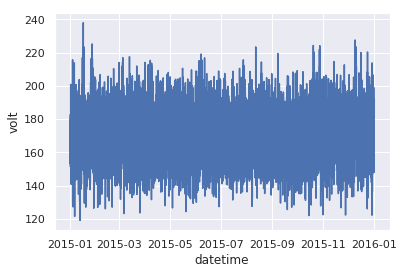

In [5]:
ax = sns.lineplot(x="datetime", y="volt", data=df_telemetry.loc[df_telemetry['machineID'] == 1, ])

Next we have the error logs, which contains information about **non-breaking** errors that happened over the course of the machine running.

In [6]:
df_errors = pd.read_csv('../data/anoms.csv', header=0)
df_errors['datetime'] = pd.to_datetime(df_errors['datetime'])
df_errors.head()

,datetime,machineID,errorID
0,2015-01-16 23:00:00,1,volt
1,2015-01-17 00:00:00,1,volt
2,2015-01-17 01:00:00,1,volt
3,2015-01-17 02:00:00,1,volt
4,2015-01-17 03:00:00,1,volt


We used **anomaly detection** to find errors in the above dataset. There are four kinds of errors, one for each of the telemetry variables we collect, namely voltage, rotation, pressure and vibration. There is a lot to be said about the topic of error detection. For examples, the errors we have here are univariate, meaning that we detect anomalies separately for each telemetry variable. We can also try a multi-variate anomaly detection algorithm. In this case, we could use a method like principal component analysis (PCA) to detect anomalies on the most important principal component(s).

### Lab

<div class="alert alert-info">
A simple question we can ask is this: Do some errors happen more often in some machines than others? In other words, what is the distribution of errors across machines?

Use `pd.crosstab` to answer the above quesion. Hint: use the `normalize` argument.
</div>

In [7]:
rep_dir = {"volt":"error1", "rotate":"error2","pressure":"error3","vibration":"error4"}
df_errors = df_errors.replace({"errorID": rep_dir})

In [8]:
ct = pd.crosstab(df_errors['machineID'], df_errors['errorID'], rownames=['device'], colnames=['error'], normalize='columns')

In [9]:
 %cat ../solutions/crosstab.py

ct = pd.crosstab(df_errors['machineID'], df_errors['errorID'], rownames=['device'], colnames=['error'], normalize='columns')

<div class="alert alert-info">
With so many machines, it may be easier to answer our question visually. We can pass the output of `pd.crosstab` directly to `sns.heatmap` to generate a heat map. How would you answer the question based on the heatmap below? Please provide examples.
</div>

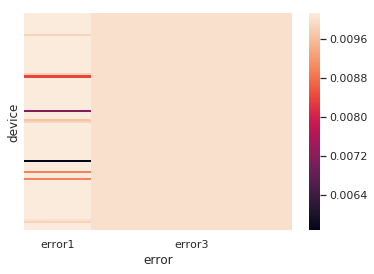

In [10]:
ax = sns.heatmap(ct, xticklabels=2, yticklabels=False)

In [11]:
%cat ../solutions/heatmap.py

ax = sns.heatmap(ct, xticklabels=2, yticklabels=False)

### End of lab

We can visualize the errors that happen on a given machine to get a sense of how they spread over time.

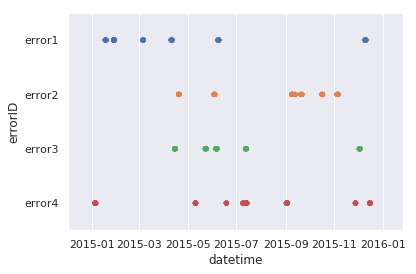

In [12]:
df_subset = df_errors.loc[(df_errors.datetime.between('2015-01-01', '2016-01-01')) & (df_errors.machineID == 1)]
df_subset.head()
ax = sns.stripplot(x="datetime", y="errorID", data=df_subset, jitter=0)
del df_subset

Let's now move on to the dataset that logs failures. As we can see, failures are logged by component (although any component failing will result in the machine as a whole failing).

In [13]:
df_fails = pd.read_csv('../data/failures.csv', header=0)
df_fails['datetime'] = pd.to_datetime(df_fails['datetime'], format="%m/%d/%Y %I:%M:%S %p")
df_fails.head()

,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4


Now we look at the dataset of maintenance log, which is also by component.

In [14]:
df_maint = pd.read_csv('../data/maintenance.csv', header=0)
df_maint['datetime'] = pd.to_datetime(df_maint['datetime'], format="%m/%d/%Y %I:%M:%S %p")
df_maint.head()

,datetime,machineID,comp
0,2014-06-01 06:00:00,1,comp2
1,2014-07-16 06:00:00,1,comp4
2,2014-07-31 06:00:00,1,comp3
3,2014-12-13 06:00:00,1,comp1
4,2015-01-05 06:00:00,1,comp4


### Lab

<div class="alert alert-info">
For each component, find the percentage of replacements that are due to component failure (as opposed to scheduled maintenance).
</div>

In [15]:
df_counts = pd.DataFrame({'replacements' : df_maint.groupby(['comp']).count()['machineID'],
                          'failures' : df_fails.groupby(['failure']).count()['machineID']})

df_counts['percent_due_to_failure'] = df_counts['failures'] / df_counts['replacements']
df_counts

,replacements,failures,percent_due_to_failure
comp1,804,192,0.238806
comp2,863,259,0.300116
comp3,808,131,0.162129
comp4,811,179,0.220715


In [16]:
 %cat ../solutions/percent_replacements.py

df_counts = pd.DataFrame({'replacements' : df_maint.groupby(['comp']).count()['machineID'],
                          'failures' : df_fails.groupby(['failure']).count()['machineID']})

df_counts['percent_due_to_failure'] = df_counts['failures'] / df_counts['replacements']
df_counts

### End of lab

We can obtain the same answer in a more detailed way by doing an **outer join** of the maintenance logs and the failure logs to see how many records matched and where they came from (in `pd.merge` we can use the `indicator=True` argument to get a column called `_merge` that indicates if the keys were present in the left, right, or both datasets.

In [17]:
df_join = pd.merge(left=df_maint, right=df_fails.rename(columns={'failure':'comp'}), how = 'outer', indicator=True,
         on=['datetime', 'machineID', 'comp'], validate='one_to_one')
df_join.head()

,datetime,machineID,comp,_merge
0,2014-06-01 06:00:00,1,comp2,left_only
1,2014-07-16 06:00:00,1,comp4,left_only
2,2014-07-31 06:00:00,1,comp3,left_only
3,2014-12-13 06:00:00,1,comp1,left_only
4,2015-01-05 06:00:00,1,comp4,both


- If a record is present in the left dataset only, it represents a working component being replaced due to scheduled maintenance.
- If a record is present in the right dataset only, it represents a failed component that was not replaced immediately. This case should be rare since it would result in downtime.
- If a record is present in both datasets, it represents a failed component that was immediately replaced (we can also call this **un-**scheduled maintenance).

We can run `pd.crosstab` to get counts for each of the above categories, broken up by component.

In [18]:
ct = pd.crosstab(df_join['comp'], df_join['_merge'], margins=True)
ct.rename(columns={"left_only":"not_failed_but_replaced", "right_only":"failed_not_replaced", "both":"failed_and_replaced"})

_merge,not_failed_but_replaced,failed_not_replaced,failed_and_replaced,All
comp,,,,
comp1,621,9,183,813
comp2,607,3,256,866
comp3,680,3,128,811
comp4,635,3,176,814
All,2543,18,743,3304


We can confirm that the second category is rare. This is usually the case in cases where downtime can result in significant costs.

The last dataset we look at is the machine metadata. In this case, we only have information about the model and age of the machine.

In [19]:
df_machines = pd.read_csv('../data/machines.csv', header=0)
df_machines.head()

,machineID,model,age
0,1,model3,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model3,2


We are now ready to move on to the next phase, where we gradually combine our datasets into one dataset that will be used for modeling and contains the features we think will be useful.

## Feature engineering

Our approach to getting the data ready for modeling will consist mainly of two things:

- for the telemetry data, we get rolling aggregates (means and standard deviation) 
- for the error, failure and maintenance logs, we get obtain the number of hours since each of these events happened

We then combine the result of the above two datasets into one, and add the machine metadata at the end. For the most part the feature engineering steps described above are relatively straight-forward, but in some cases we need to process the data in creative ways to get the results we want.

In [21]:
df_left = df_telemetry.loc[:, ['datetime', 'machineID']] # we set this aside to this table to join all our results with

# this will make it easier to automatically create features with the right column names
df_errors['error'] = df_errors['errorID'].apply(lambda x: int(x[-1]))
df_maint['comp'] = df_maint['comp'].apply(lambda x: int(x[-1]))
df_fails['failure'] = df_fails['failure'].apply(lambda x: int(x[-1]))

TypeError: 'int' object is not subscriptable

Let's begin with a function that will give us rolling mean and standard deviation for the telemetry data.

In [22]:
import numpy as np

def get_rolling_aggregates(df, colnames, suffixes, window, on, groupby, lagon = None):
    """
    calculates rolling averages and standard deviations
    
    Arguments:
    df -- dataframe to run it on
    colnames -- names of columns we want rolling statistics for
    suffixes -- suffixes attached to the new columns (provide a list with strings)
    window -- the lag over which rolling statistics are calculated
    on -- the interval at which rolling statistics are calculated
    groupby -- the column used to group results by
    lagon -- the name of the datetime column used to compute lags (if none specified it defaults to row number)
      
    Returns:
    a dataframe with rolling statistics over a specified lag calculated over a specified interval
    """
    
    rolling_colnames = [c + suffixes[0] for c in colnames]
    df_rolling_mean = df.groupby(groupby).rolling(window=window, on=lagon)[colnames].mean()
    df_rolling_mean.columns = rolling_colnames
    df_rolling_mean.reset_index(inplace=True)
    
    rolling_colnames = [c + suffixes[1] for c in colnames]
    df_rolling_sd = df.groupby(groupby).rolling(window=window, on=lagon)[colnames].var()
    df_rolling_sd.columns = rolling_colnames
    df_rolling_sd = df_rolling_sd.apply(np.sqrt)
    df_rolling_sd.reset_index(inplace=True, drop=True)
    
    df_res = pd.concat([df_rolling_mean, df_rolling_sd], axis=1)
    df_res = df_res.loc[df_res.index % on == on-1]
    return df_res

We will apply this function twice, once to get rolling aggregates using a sliding window of 3 hours collected every 3 hours, and a second time to get rolling aggregates using a sliding window of 12 hours also collected every 3 hours.

In [23]:
cols_to_average = df_telemetry.columns[-4:]

df_telemetry_rolling_3h = get_rolling_aggregates(df_telemetry, cols_to_average, 
                                                 suffixes = ['_ma_3', '_sd_3'], 
                                                 window = 3, on = 3, 
                                                 groupby = 'machineID', lagon = 'datetime')
# df_telemetry_rolling_3h.head(20)

In [24]:
df_telemetry_rolling_12h = get_rolling_aggregates(df_telemetry, cols_to_average, 
                                                  suffixes = ['_ma_12', '_sd_12'], 
                                                  window = 12, on = 3, 
                                                  groupby = 'machineID', lagon = 'datetime')
# df_telemetry_rolling_12h.head(20)

We can combine both results into a single table and back-fill any missing values.

In [25]:
df_telemetry_rolling = pd.concat([df_telemetry_rolling_3h, df_telemetry_rolling_12h.drop(['machineID', 'datetime'], axis=1)], 
                              axis=1, sort = True)
# df_telemetry_rolling.head()

In [26]:
df_telemetry_feat_roll = df_left.merge(df_telemetry_rolling, how="inner", on=['machineID', 'datetime'], validate = "one_to_one")
df_telemetry_feat_roll.fillna(method='bfill', inplace=True)
df_telemetry_feat_roll.head()

,datetime,machineID,volt_ma_3,rotate_ma_3,pressure_ma_3,vibration_ma_3,volt_sd_3,rotate_sd_3,pressure_sd_3,vibration_sd_3,volt_ma_12,rotate_ma_12,pressure_ma_12,vibration_ma_12,volt_sd_12,rotate_sd_12,pressure_sd_12,vibration_sd_12
0,2015-01-01 08:00:00,1,170.028993,449.533798,94.592122,40.893502,6.721032,67.849599,18.934956,5.874970,166.967614,429.934546,102.444134,39.190634,6.849631,49.650872,10.782098,5.619049
1,2015-01-01 11:00:00,1,164.192565,403.949857,105.687417,34.255891,7.596570,50.120452,8.555032,7.662229,166.967614,429.934546,102.444134,39.190634,6.849631,49.650872,10.782098,5.619049
2,2015-01-01 14:00:00,1,168.134445,435.781707,107.793709,41.239405,10.124584,55.084734,5.909721,5.169304,166.967614,429.934546,102.444134,39.190634,6.849631,49.650872,10.782098,5.619049
3,2015-01-01 17:00:00,1,165.514453,430.472823,101.703289,40.373739,4.673269,42.047278,4.554047,2.106108,166.967614,429.934546,102.444134,39.190634,6.849631,49.650872,10.782098,5.619049
4,2015-01-01 20:00:00,1,168.809347,437.111120,90.911060,41.738542,14.752132,47.048609,4.244158,2.207884,166.662702,426.828877,101.523869,39.401894,8.748726,43.925228,8.536877,5.207254


In [27]:
del df_telemetry_rolling, df_telemetry_rolling_3h, df_telemetry_rolling_12h

We now write a function that takes care of extracting features showing when events (errors, failures, replacements) occured. The data is then passed to the same 3-hour sliding filter as the telemetry data. Using a rolling max function, we compute if there was an event sometime in the last 3 hours. Finally we compute time elapsed since the last event. 

We use the following naming convention for the column names in the final dataset. For a given machine at a given date and time:

- `e_1` is a flag indicating if error 1 occured, likewise for `e_2` through `e_5`
- `de_1` is a numeric feature that represents the hours elapsed since the last time error 1 occured, likewise for `de_2` through `de_5`
- `m_1` is a flag indicating if component 1 was replaced, likewise for `m_2` through `m_4`
- `dm_1` is a numeric feature that represents the hours elapsed since the last time component 1 was replaced, likewise for `dm_2` through `dm_4`
- `f_1` is a flag indicating if component 1 failed, likewise for `f_2` through `f_4`
- `df_1` is a numeric feature that represents the hours elapsed since the last time component 1 failed, likewise for `df_2` through `df_4`

Finally, we will use `f_1` through `f_4` to create the targets `y_1` through `y_4`:
- `y_1` is a flag indicating if component 1 is about to fail, likewise for `y_2` through `y_4`

In [28]:
def get_datetime_diffs(df_left, df_right, catvar, prefix, window, on, lagon = None, diff_type = 'timedelta64[h]', validate = 'one_to_one', show_example = True):
    """
    finds the last time an event (error, failure, maintenance) happened over a sliding window and the time elapsed since
    
    Arguments:
    df_left -- dataframe with keys
    df_right -- dataframe with events (in this case: errors, failures, or maintenance)
    catvar -- the column in df_right which encodes events
    prefix -- prefix to add to new column names
    window -- the lag over which rolling max is calculated
    on -- the interval at which rolling max are calculated
    lagon -- the name of the datetime column used to compute lags (if none specified it defaults to row number)
    diff_type -- the format to convert time differences to (hours is the default)
    validate -- set to 'one_to_one' to ensure the validity of the ensuing merge operation
    show_example -- prints an example so we can check results
    
    Returns:
    the dataframe with the following columns for each event: 
      - a dummy column showing which event happened
      - a corresponding difference column showing the time elapsed since the event last occured
    """

    # create dummy columns and merge them with left data
    keys = ['machineID', 'datetime']
    df_dummies = pd.get_dummies(df_right[catvar], prefix=prefix)
    df_wide = pd.concat([df_right.loc[:, keys], df_dummies], axis=1)
    df_wide = df_wide.groupby(keys).sum().reset_index()
    df = df_left.merge(df_wide, how="left", on=keys, validate = validate).fillna(0)

    # run a rolling window through event flags to aggregate data
    dummy_col_names = df_dummies.columns
    df = df.groupby('machineID').rolling(window=window, on=lagon)[dummy_col_names].max()
    df.reset_index(inplace=True)
    df = df.loc[df.index % on == on-1]
    df.reset_index(inplace=True, drop=True)

    df_first = df.groupby('machineID', as_index=False).nth(0)
    # calculate the time of the last event and the time elapsed since
    for col in dummy_col_names:
        whenlast, diffcol = 'last_' + col, 'd' + col
        df.loc[:, col].fillna(value = 0, inplace=True)
        # let's assume an event happened in row 0, so we don't have missing values for the time elapsed
        df.iloc[df_first.index, df.columns.get_loc(col)] = 1
        
        df.loc[df[col] == 1, whenlast] = df.loc[df[col] == 1, 'datetime']
        # for the first occurence we don't know when it last happened, so we assume it happened then
        df.iloc[df_first.index, df.columns.get_loc(whenlast)] = df.iloc[df_first.index, df.columns.get_loc('datetime')]
        df[whenlast].fillna(method='ffill', inplace=True)
        
        # df.loc[df[whenlast] > df['datetime'], whenlast] = np.nan
        df.loc[df[whenlast] <= df['datetime'], diffcol] = (df['datetime'] - df[whenlast]).astype(diff_type)
        df.drop(columns = whenlast, inplace=True)
    
    if show_example == True:
        col = np.random.choice(dummy_col_names, size = 1)[0]
        idx = np.random.choice(df.loc[df[col] == 1, :].index.tolist(), size = 1)[0]
        print('Example:\n')
        print(df.loc[df.index.isin(range(idx-3, idx+5)), ['datetime', col, 'd' + col]])
    
    return df

In [29]:
df_errors_feat_roll = get_datetime_diffs(df_left, df_errors, catvar='errorID', prefix='e', window = 6, lagon = 'datetime', on = 3)
df_errors_feat_roll.tail()

Example:

                  datetime  e_error3  de_error3
237109 2015-03-12 14:00:00       1.0        0.0
237110 2015-03-12 17:00:00       1.0        0.0
237111 2015-03-12 20:00:00       1.0        0.0
237112 2015-03-12 23:00:00       1.0        0.0
237113 2015-03-13 02:00:00       1.0        0.0
237114 2015-03-13 05:00:00       1.0        0.0
237115 2015-03-13 08:00:00       1.0        0.0
237116 2015-03-13 11:00:00       1.0        0.0


,machineID,datetime,e_error1,e_error2,e_error3,e_error4,de_error1,de_error2,de_error3,de_error4
292028,100,2015-12-31 17:00:00,0.0,0.0,0.0,0.0,2694.0,534.0,5118.0,1299.0
292029,100,2015-12-31 20:00:00,0.0,0.0,0.0,0.0,2697.0,537.0,5121.0,1302.0
292030,100,2015-12-31 23:00:00,0.0,0.0,0.0,0.0,2700.0,540.0,5124.0,1305.0
292031,100,2016-01-01 02:00:00,0.0,0.0,0.0,0.0,2703.0,543.0,5127.0,1308.0
292032,100,2016-01-01 05:00:00,0.0,0.0,0.0,0.0,2706.0,546.0,5130.0,1311.0


In [30]:
df_errors_feat_roll.loc[df_errors_feat_roll['machineID'] == 2, :].head()

,machineID,datetime,e_error1,e_error2,e_error3,e_error4,de_error1,de_error2,de_error3,de_error4
2920,2,2015-01-01 07:00:00,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
2921,2,2015-01-01 10:00:00,0.0,0.0,0.0,0.0,3.0,3.0,3.0,3.0
2922,2,2015-01-01 13:00:00,0.0,0.0,0.0,0.0,6.0,6.0,6.0,6.0
2923,2,2015-01-01 16:00:00,0.0,0.0,0.0,0.0,9.0,9.0,9.0,9.0
2924,2,2015-01-01 19:00:00,0.0,0.0,0.0,0.0,12.0,12.0,12.0,12.0


In [31]:
df_maint_feat_roll = get_datetime_diffs(df_left, df_maint, catvar='comp', prefix='m', 
                                        window = 6, lagon = 'datetime', on = 3, show_example=False)
df_maint_feat_roll.tail()

,machineID,datetime,m_1,m_2,m_3,m_4,dm_1,dm_2,dm_3,dm_4
292028,100,2015-12-31 17:00:00,0.0,0.0,0.0,0.0,1974.0,174.0,1974.0,1254.0
292029,100,2015-12-31 20:00:00,0.0,0.0,0.0,0.0,1977.0,177.0,1977.0,1257.0
292030,100,2015-12-31 23:00:00,0.0,0.0,0.0,0.0,1980.0,180.0,1980.0,1260.0
292031,100,2016-01-01 02:00:00,0.0,0.0,0.0,0.0,1983.0,183.0,1983.0,1263.0
292032,100,2016-01-01 05:00:00,0.0,0.0,0.0,0.0,1986.0,186.0,1986.0,1266.0


In [32]:
df_maint_feat_roll.loc[df_maint_feat_roll['machineID'] == 2, :].head()

,machineID,datetime,m_1,m_2,m_3,m_4,dm_1,dm_2,dm_3,dm_4
2920,2,2015-01-01 07:00:00,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
2921,2,2015-01-01 10:00:00,0.0,0.0,0.0,0.0,3.0,3.0,3.0,3.0
2922,2,2015-01-01 13:00:00,0.0,0.0,0.0,0.0,6.0,6.0,6.0,6.0
2923,2,2015-01-01 16:00:00,0.0,0.0,0.0,0.0,9.0,9.0,9.0,9.0
2924,2,2015-01-01 19:00:00,0.0,0.0,0.0,0.0,12.0,12.0,12.0,12.0


In [33]:
df_fails_feat_roll = get_datetime_diffs(df_left, df_fails, catvar='failure', prefix='f', 
                                        window = 6, lagon = 'datetime', on = 3, show_example=False)
df_fails_feat_roll.tail()

,machineID,datetime,f_1,f_2,f_3,f_4,df_1,df_2,df_3,df_4
292028,100,2015-12-31 17:00:00,0.0,0.0,0.0,0.0,2694.0,534.0,8745.0,8745.0
292029,100,2015-12-31 20:00:00,0.0,0.0,0.0,0.0,2697.0,537.0,8748.0,8748.0
292030,100,2015-12-31 23:00:00,0.0,0.0,0.0,0.0,2700.0,540.0,8751.0,8751.0
292031,100,2016-01-01 02:00:00,0.0,0.0,0.0,0.0,2703.0,543.0,8754.0,8754.0
292032,100,2016-01-01 05:00:00,0.0,0.0,0.0,0.0,2706.0,546.0,8757.0,8757.0


### Combine features in one dataset

We now combine all four datasets into one dataset called `df_all`.  First we check of course that all data frames have the same dimensions.

In [34]:
assert(df_errors_feat_roll.shape[0] == df_fails_feat_roll.shape[0] == df_maint_feat_roll.shape[0] == df_telemetry_feat_roll.shape[0])


In [35]:
df_all = pd.concat([df_telemetry_feat_roll,
                    df_errors_feat_roll.drop(columns=['machineID', 'datetime']), 
                    df_maint_feat_roll.drop(columns=['machineID', 'datetime']), 
                    df_fails_feat_roll.drop(columns=['machineID', 'datetime'])], axis = 1, verify_integrity=True)

# df_all = pd.merge(left=df_telemetry_feat_roll, right=df_all, on = ['machineID', 'datetime'], validate='one_to_one')
df_all = pd.merge(left=df_all, right=df_machines, how="left", on='machineID', validate = 'many_to_one')

In [36]:
del df_join, df_left

In [37]:
del df_telemetry_feat_roll, df_errors_feat_roll, df_fails_feat_roll, df_maint_feat_roll

### Lab

<div class="alert alert-info">
This may be a good place to stop and look at the correlation matrix for all the features we have in the data. We expect some obvious correlations, but let's see if we get any less obvious ones too. We will use `sns.heatmap` to visualize the correlation matrix.
</div>

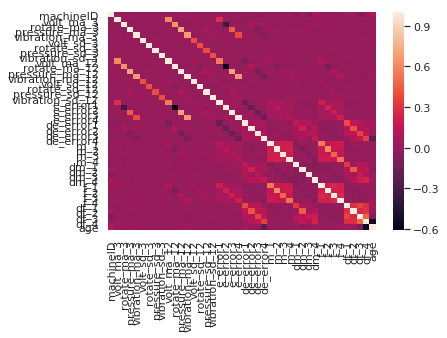

In [39]:
import seaborn as sns
corr = df_all.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [38]:
 %cat ../solutions/correlation_matrix.py

import seaborn as sns
corr = df_all.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

<div class="alert alert-info">
Describe what you see in the correlation matrix. What would relatively high correlations between `m_1` through `m_4` suggest? What about the relatively high correlations between `m_1` through `m_4` and `f_1` through `f_4`?
</div>

<div class="alert alert-info">
We can export the data for one of the machines to a CSV file. Export the subset of the data corresponding to the machine with ID 51 to CSV, then download the CSV file and open it in Excel to examine its content. Comment on what you see.
</div>

In [41]:
df_all.loc[(df_all['machineID'] == 51), :].sort_values(['datetime', 'machineID']).to_csv('bla.csv')

In [40]:
%cat ../solutions/export_csv.py

df_all.loc[(df_all['machineID'] == 51), :].sort_values(['datetime', 'machineID']).to_csv('bla.csv')

### End of lab

Let's look at all the features we've so far added to the data.

In [42]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 292033 entries, 0 to 292032
Data columns (total 44 columns):
datetime           292033 non-null datetime64[ns]
machineID          292033 non-null int64
volt_ma_3          292033 non-null float64
rotate_ma_3        292033 non-null float64
pressure_ma_3      292033 non-null float64
vibration_ma_3     292033 non-null float64
volt_sd_3          292033 non-null float64
rotate_sd_3        292033 non-null float64
pressure_sd_3      292033 non-null float64
vibration_sd_3     292033 non-null float64
volt_ma_12         292033 non-null float64
rotate_ma_12       292033 non-null float64
pressure_ma_12     292033 non-null float64
vibration_ma_12    292033 non-null float64
volt_sd_12         292033 non-null float64
rotate_sd_12       292033 non-null float64
pressure_sd_12     292033 non-null float64
vibration_sd_12    292033 non-null float64
e_error1           292033 non-null float64
e_error2           292033 non-null float64
e_error3           29203

The last step in data prep is for us to create labels for the PdM model. You might wonder why we don't just use `f_1` through `f_4` as our labels, since they indicate when a machine failed. In fact we could, but PdM is not about predicting when a machine fails, but predicting when it's **about to fail**. So it's better to create labels indicate the state of the machine shortly prior to failure (how far back we want to go is something we need to determine).

### Lab

<div class="alert alert-info">
This is a difficult coding exercise, so we've done part of the work for you already. So far we know that we each machine has four components, and we have a feature column for each, called `f_1`, `f_2`, `f_3`, and `f_4` which tell us when a component failed. Using these features, we want to create four labels called `y_1`, `y_2`, `y_3`, and `y_4` which tell us when a component is about to fail. To get more precise, initiate with `y_1 = 0` and for a given machine, let `y_1 = 1` whenever the date and time is anywhere between 3 hours and 2 days prior to a failure occuring. Similary compute `y_2`, `y_3`, and `y_4`. Places where you need to enter code are marked as `## YOUR CODE GOES HERE`. HINT: Use the `Timedelta` method for `datetime` column types.
</div>

In [43]:
for i in range(1, 5): # iterate over the four components
    # find all the times a component failed for a given machine
    df_temp = df_all.loc[df_all['f_' + str(i)] == 1, ['machineID', 'datetime']]
    label = 'y_' + str(i) # name of target column (one per component)
    ## YOUR CODE GOES HERE (initialize y_i = 0)
    for n in range(df_temp.shape[0]): # iterate over all the failure times
        machineID, datetime = df_temp.iloc[n, :]
        ## YOUR CODE GOES HERE (set y_i = 1 whenever datetime is between 2 days and 3 hours prior to failure)

In [46]:
# %load ../solutions/compute_labels.py
for i in range(1, 5): # iterate over the four components
    # find all the times a component failed for a given machine
    df_temp = df_all.loc[df_all['f_' + str(i)] == 1, ['machineID', 'datetime']]
    label = 'y_' + str(i) # name of target column (one per component)
    df_all[label] = 0
    for n in range(df_temp.shape[0]): # iterate over all the failure times
        machineID, datetime = df_temp.iloc[n, :]
        dt_end = datetime - pd.Timedelta('3 hours') # 3 hours prior to failure
        dt_start = datetime - pd.Timedelta('2 days') # n days prior to failure
        if n % 500 == 0: 
            print("a failure occured on machine {0} at {1}, so {2} is set to 1 between {4} and {3}".format(machineID, datetime, label, dt_end, dt_start))
        df_all.loc[(df_all['machineID'] == machineID) & 
                   (df_all['datetime'].between(dt_start, dt_end)), label] = 1

a failure occured on machine 1 at 2015-01-01 08:00:00, so y_1 is set to 1 between 2014-12-30 08:00:00 and 2015-01-01 05:00:00
a failure occured on machine 1 at 2015-01-01 08:00:00, so y_2 is set to 1 between 2014-12-30 08:00:00 and 2015-01-01 05:00:00
a failure occured on machine 82 at 2015-12-09 08:00:00, so y_2 is set to 1 between 2015-12-07 08:00:00 and 2015-12-09 05:00:00
a failure occured on machine 1 at 2015-01-01 08:00:00, so y_3 is set to 1 between 2014-12-30 08:00:00 and 2015-01-01 05:00:00
a failure occured on machine 1 at 2015-01-01 08:00:00, so y_4 is set to 1 between 2014-12-30 08:00:00 and 2015-01-01 05:00:00


<div class="alert alert-info">
To run the above script change the magic `%cat` to `%load` which will load the content of the script into the cell. Then select the cell a second time and run it.
</div>

### End of lab

In [47]:
import itertools

ct = pd.concat([pd.crosstab(df_all['y_' + str(i)], df_all['f_' + str(i)]) for i in range(1, 5)], axis=1)
ct.columns = ['f' + str(i) + '=' + str(j) for i, j in itertools.product(range(1, 5), range(2))]
ct

,f1=0,f1=1,f2=0,f2=1,f3=0,f3=1,f4=0,f4=1
0,288585,281,287301,356,289614,227,288741,276
1,2964,203,4114,262,2057,135,2834,182


A word of caution here is in order. We should more carefully examine the distribution of the labels across machines. A brief glance at it for 10 randomly chosen machines shows that the distribution for `y_3` and `y_4` is not evenly distributed and that many machines contain only negative labels (because `f_3` and `f_4` are 0) while the machines with positive labels show a large numbers of failures. Problems like this can cause bias in our models, even when such differences can be legimtimately explained away by differences in the underlying components. As an example of the kind of problem we may run into, consider this: If in the modeling phase we choose to split the data into training and testing by machine ID (assign some machine IDs to training and the rest to testing), we will need to ensure that machines with both positive and negative labels are well represented in both datasets.

In [48]:
import itertools

ct = pd.concat([pd.crosstab(df_all['machineID'], 
                            df_all['y_' + str(i)]) for i in range(1, 5)], axis=1)
ct.columns = ['y_' + str(i) + '=' + str(j) for i, j in itertools.product(range(1, 5), range(2))]
ct.loc[np.random.randint(1, 100, 10)]

,y_1=0,y_1=1,y_2=0,y_2=1,y_3=0,y_3=1,y_4=0,y_4=1
machineID,,,,,,,,
36,2887,34,2887,34,2921,0,2921,0
7,2869,51,2852,68,2920,0,2869,51
33,2887,34,2870,51,2921,0,2853,68
41,2869,51,2920,0,2920,0,2920,0
57,2887,34,2921,0,2921,0,2921,0
83,2852,68,2852,68,2920,0,2827,93
23,2903,17,2869,51,2852,68,2852,68
49,2920,0,2869,51,2852,68,2835,85
66,2853,68,2904,17,2921,0,2921,0


## Modeling

See [here](https://docs.microsoft.com/en-us/azure/machine-learning/team-data-science-process/cortana-analytics-playbook-predictive-maintenance#modeling-techniques-for-predictive-maintenance) for more about modeling approaches for PdM.

We constructed a binary label that can be used to predict the probability that the system will fail in the next $T$ time steps (48 hours, based on our specified choice). If explanability is also a goal here, then we should prefer models that can also help us explain the root cause of a failure.

We have two ways of splitting the data into training and testing:
- we choose a cut-off time $T_c$ such that the training data is all the data before $T_c - w$ and the test data is all the data after $T_c$, where $w$ is a safe margin to make sure that as we avoid leakage into the training data when we label the data
- we split training and test set based machine ID so that assets show up in one or the other split

For your benefit, here is a list of [solution templates for predictive maintenance](https://docs.microsoft.com/en-us/azure/machine-learning/team-data-science-process/cortana-analytics-playbook-predictive-maintenance#solution-templates-for-predictive-maintenance).

In [49]:
df_all.columns

Index(['datetime', 'machineID', 'volt_ma_3', 'rotate_ma_3', 'pressure_ma_3',
       'vibration_ma_3', 'volt_sd_3', 'rotate_sd_3', 'pressure_sd_3',
       'vibration_sd_3', 'volt_ma_12', 'rotate_ma_12', 'pressure_ma_12',
       'vibration_ma_12', 'volt_sd_12', 'rotate_sd_12', 'pressure_sd_12',
       'vibration_sd_12', 'e_error1', 'e_error2', 'e_error3', 'e_error4',
       'de_error1', 'de_error2', 'de_error3', 'de_error4', 'm_1', 'm_2', 'm_3',
       'm_4', 'dm_1', 'dm_2', 'dm_3', 'dm_4', 'f_1', 'f_2', 'f_3', 'f_4',
       'df_1', 'df_2', 'df_3', 'df_4', 'model', 'age', 'y_1', 'y_2', 'y_3',
       'y_4'],
      dtype='object')

Let's begin by splitting the data into training and test sets, based on a date cut-off.

In [50]:
X_drop = ['datetime', 'machineID', 'f_1', 'f_2', 'f_3', 'f_4', 'y_1', 'y_2', 'y_3', 'y_4', 'model']
Y_keep = ['y_1', 'y_2', 'y_3', 'y_4']

X_train = df_all.loc[df_all['datetime'] < '2015-10-01', ].drop(X_drop, axis=1)
y_train = df_all.loc[df_all['datetime'] < '2015-10-01', Y_keep]

X_test = df_all.loc[df_all['datetime'] > '2015-10-15', ].drop(X_drop, axis=1)
y_test = df_all.loc[df_all['datetime'] > '2015-10-15', Y_keep]

In [51]:
%store X_train ../data
%store X_test ../data
%store y_train ../data
%store y_test ../data

Stored 'X_train' (DataFrame)
Stored 'X_test' (DataFrame)
Stored 'y_train' (DataFrame)
Stored 'y_test' (DataFrame)


### Lab

<div class="alert alert-info">
Report the number of failures that occur in the training and test data. Do you think the split is adequate or should we split based on a different cut-off? If so, do you recommend a higher or lower cut-off?
</div>

In [55]:
print(pd.DataFrame({"train": y_train.apply(sum, axis = 0), "test": y_test.apply(sum, axis = 0)}))

     train  test
y_1   2530   578
y_2   3172   990
y_3   1728   408
y_4   2333   629


In [54]:
 %cat ../solutions/train_test_failures.py

print(pd.DataFrame({"train": y_train.apply(sum, axis = 0), "test": y_test.apply(sum, axis = 0)}))

### End of lab

We can now train our model. We have chosen a MLP (multi-linear perceptron) as our model, which is a basic neural network model.

In [56]:
pipeline = Pipeline([('scaler', StandardScaler()), ('classifier', MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 10), random_state=1))])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

### Lab

<div class="alert alert-info">
Print the confusion matrix and precision and recall for each of the four failure types. You can use the functions `confusion_matrix` and `classification report` to do the computation for you.  The rows in the matrix represent actual cases of non-failure and failure. The columns represent predicted cases. How is precision and recall calculated from the confusion matrix?
</div>

In [57]:
# write solution here

In [58]:
# %load ../solutions/confusion_matrix.py
print("confusion matrix:")
for y_idx in range(4):
    print("---------------- for y_" + str(y_idx+1))
    print(confusion_matrix(y_test.values[:, y_idx], y_pred[:, y_idx]))
    
print("\nclassification report:")
print(classification_report(y_test, y_pred))
print("AUC = {}".format(roc_auc_score(y_test, y_pred, average='weighted')))

confusion matrix:
---------------- for y_1
[[61907   115]
 [  431   147]]
---------------- for y_2
[[61534    76]
 [  926    64]]
---------------- for y_3
[[62022   170]
 [  250   158]]
---------------- for y_4
[[61803   168]
 [  408   221]]

classification report:
             precision    recall  f1-score   support

          0       0.56      0.25      0.35       578
          1       0.46      0.06      0.11       990
          2       0.48      0.39      0.43       408
          3       0.57      0.35      0.43       629

avg / total       0.51      0.23      0.29      2605

AUC = 0.6122623056675458


### End of lab

Finally, let's create ROC plots for each type of failure.

In [59]:
sns.set(rc={'figure.figsize':(18,5)})

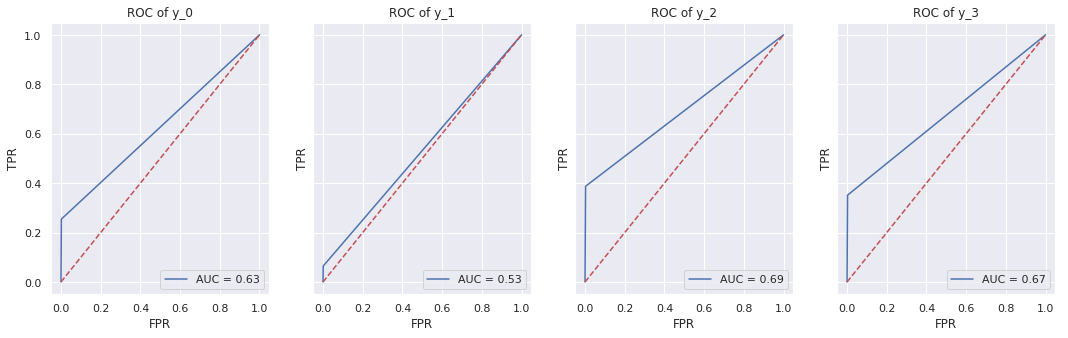

In [60]:
from sklearn.metrics import auc, roc_curve

plt.close('all')
fig, axs = plt.subplots(ncols=4, sharex=True, sharey=True)

for y_idx in range(4): # choose one of the outcomes
    fpr, tpr, thresholds = roc_curve(y_test.values[:, y_idx], y_pred[:, y_idx])
    roc_auc = auc(fpr, tpr)
    axs[y_idx].set_title('ROC of y_' + str(y_idx))
    axs[y_idx].set_ylabel('TPR')
    axs[y_idx].set_xlabel('FPR')
    axs[y_idx].plot(fpr, tpr, 'b', label = 'AUC = {0:.2f}'.format(roc_auc))
    axs[y_idx].legend(loc = 'lower right')
    axs[y_idx].plot([0, 1], [0, 1],'r--')

plt.show()

Let's store the training and test data so we can reload it in the next Notebook.

# The end

Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.